<a href="https://colab.research.google.com/github/arnauddyevre/ec539_assignment1/blob/master/EC539_assignment1_Dyevre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EC539 - Assignment 1
Reproduction of the numerical results in *N. Kiyotaki & J. Moore* "Credit Cycles" (1997) 

*Sunday, January 06*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arnauddyevre/Python-for-Social-Scientists/blob/master/statistics_and_econometrics/time_series/time_series.ipynb)

This Notebook presents the tools we need to analyse time series in Python.

We first review some essential results about covariance stationarity and strict stationarity, MA, AR and ARMA processes. We then use the `statsmodels` library to decompose seasonal time series into trends and cyclical components, we show how to do time series forecasting and how to use common filters. Finally, we implement tests of unit roots in `statsmodels`.

Some familiarity with time-series is required.

### Content

- [1. Setup](#1.-Setup)
    - [1.1. Parameter values](#1.1.-Parameter-values)
    - [1.2. Model equilibrium](#1.2.-Model-equilibrium)
    - [1.3. Wold's decomposition theorem](#1.3.-Wold's-decomposition-theorem)
    - [1.4. AR(p) processes](#1.4.-AR(p)-processes)
    - [1.5. MA(p) processes](#1.5.-MA(q)-processes)
    - [1.6. ARMA(p, q) processes](#1.6.-ARMA(p,-q)-processes)
- [2. Time series in statsmodels](#2.-Time-series-in-statsmodels)
    - [2.1. Seasonal decomposition](#2.1.-Seasonal-decomposition)
    - [2.2. Time series forecasting](#2.2.-Time-series-forecasting)
    - [2.3. Time series filters](#2.3.-Time-series-filters)
    - [2.4. Tests of stationarity and unit roots](#2.4.-Tests-of-stationarity-and-unit-roots)

### 1. Setup

### 1.1. Assumptions

#### 1.2. Parameter values

$R = 1.01 \\
\lambda = 0.975\\
u(K) = K - v\\
\eta = 0.10 \\
a = 1\\
\pi = 0.1\\
\phi = 20\\
\Delta = 0.01\\
c = 1$

#### 1.3. Model equilibrium

*(1) Land market equilibrium condition*
$$q_{t+1}= R(q_{t} - u\left(K_{t}\right))$$

*(2) Law of motion of the farmers' aggregate landholding*
$$\begin{equation}
K_{t}=(1-\pi) \lambda K_{t-1} +\frac{\pi}{\phi + q_t - \frac{1}{R} q_{t+1}}\left[\left(a+q_{t}+\lambda \phi\right) K_{t-1}-R B_{t-1}\right]
\end{equation}$$

*(3) Law of motion of the farmers' aggregate debt*
$$B_{t}=R B_{t-1}+q_{t}\left(K_{t}-K_{t-1}\right)+\phi\left(K_{t}-\lambda K_{t-1}\right)-a K_{t-1}$$

Where:

- $ q_t = $ price of land 
- $K_t=$ landholding of farmers
- $ B_t = $ aggregate debt of farmers
- $R_t = R = $ constant rate of interest
- $u(.) =$ downpayment required for the purchase of $K_t$ units or land (or opportunity cost of holding land)
- $a = $ constant proportional to the share of tradeable fruit
- $\lambda =$ fraction of trees surviving after one period
- $\pi = $ probability that a new opportunity to plant tree arises
- $\phi = $ amount of trees created with one fruit  

I simulate this non-linear model.

#### 1.4. (No NEED!) Linearisation around the steady state

Equations (1), (2) and (3) form a nonlinear system that I need to solve for $(K_{t}^{*}, B_{t}^*, q_{t}^*)$. I linearise the model around its steady state

*Steady state*
$$\begin{align} 
\frac{R-1}{R} q^{*}=u^{*} & =\frac{\pi a-(1-\lambda)(1-R+\pi R) \phi}{\lambda \pi+(1-\lambda)(1-R+\pi R)} \\
u^{*} & =\frac{1}{R} G^{\prime}\left[\frac{1}{m}\left(\bar{K}-K^{*}\right)\right] \\
B^{*} & =\frac{1}{R-1}(a-\phi+\lambda \phi) K^{*}
\end{align}$$

To find the steady state value of $K$, we instead use (1): $$K^* = \frac{R - 1}{R} q^* + \nu$$ 


In the text of the paper, $\eta$ is defined as the elasticity of the residual supply of land to the farmers with respect to the user/opportunity cost in the steady state. We can thus calculate $v$ in the expression of $u(K) = K - v$ that we are assuming.

$$ \dfrac{1}{\eta} = \left . \dfrac{\mathrm{d} \log(K - \nu)}{\mathrm{d} log(K)} \right|_{K = K^*} = \left.\dfrac{\mathrm{d} (K - \nu)}{\mathrm{d}K}\right|_{K=K^*} \dfrac{K^*}{K^*-\nu} = \dfrac{K^*}{K^*-\nu} $$

So $v = K^*(1 - \eta)$ and $K^* = \frac{R - 1}{R} \dfrac{q^*}{\eta}$

#### 1.5. Impact of a small change in productivity




In [0]:
#Necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import scipy.optimize as opt
#%matplotlib nbagg

In [2]:
#Setting timeline
periods = 100                                       
trials = 1000000

#Vectors of variable of interest
B = np.zeros(periods)
q = np.zeros(periods)
K = np.zeros(periods)

#Parameter values
R = 1.01
λ = 0.975
v = 1.0
η = 0.10
a = 1.0
Δa = 0.01
π = 0.1
ϕ = 20.0
Δ = 0.01
c = 1.0

#Finding the steady state values
q_star = (R/(R-1))*(π*a - (1-λ)*(1 - R + π*R)*ϕ) / (λ*π + (1-λ)*(1 - R + π*R))
K_star = ((R-1)/R)*(q_star/η)
B_star = (1/(R-1))*(a - ϕ + λ*ϕ)*K_star
q_star, K_star, B_star

(55.1691305437233, 5.462290152843895, 273.11450764219455)

In [3]:
#Calculating the values of q, B and K after the productivity shock (need to solve non-linear equations for each period)
a_t = np.ones(periods)
a_t[1] = a + Δa
B[0], K[0] = B_star, K_star
q[0] = q_star
a_t

array([1.  , 1.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  ])

I need to use shooting method to solve for this nonlinear dynamic problem. For this, I need two boundary conditions.

$$ (q_0, B_0, K_0) = (q^*, B^*, K^*) $$ and $$ (q_\infty, B_\infty, K_\infty) = (q^g, B^g, K^g) $$ where $(q^g, B^g, K^g)$ are guesses for the final values of our variables of interest.

And my three dynamic equations.

Use reverse shooting here.

In [0]:
#t = 1

#def f(variables):
#  (q_tplus1, K_t, B_t) = variables
#  first_eq = q_tplus1 - R*(q[t] - K[t-1] - v)
#  sec_eq = K_t - (1 - π)*λ*K[t-1] - ((π)/(ϕ + q[t] - (1/R)*q_tplus1))*( (a_t[t] + q[t] + λ*ϕ)*K[t-1] - R*B[t-1])
#  third_eq = B_t - R*B[t] - q[t]*(K[t]-K[t-1]) - ϕ*(K[t]-λ*K[t-1]) + a_t[t]*K[t-1]
#  return [first_eq, sec_eq, third_eq]
          
#solution = opt.fsolve(f, (0, 0, 0))
#print(solution)

In [5]:
#Vectors of variable of interest
B = np.zeros(periods)
q = np.zeros(periods)
K = np.zeros(periods)

#Calculating the values of q, B and K after the productivity shock (need to solve non-linear equations for each period)
a_t = np.ones(periods)
a_t[1] = a + Δa
B[0], K[0] = B_star, K_star
a_t

#Generating test values for q_1, checking which ones lead to the steady state
q_vec = np.linspace(q_star*(1.0037-0.00005), q_star*(1.0037+0.00005), trials)
q_vecSS = np.linspace(q_star, q_star, trials)
q_mat = np.zeros((trials, 100))
q_mat[:,1] = q_vec
q_mat[:,0] = q_vecSS

B_mat = np.zeros((trials, 100))
K_mat = np.zeros((trials, 100))
B_vec = np.linspace(B_star, B_star, trials)
K_vec = np.linspace(K_star, K_star, trials)
B_mat[:,0] = B_vec
K_mat[:,0] = K_vec
q_vec

array([55.37049787, 55.37049788, 55.37049788, ..., 55.37601477,
       55.37601478, 55.37601478])

In [6]:

for s in range(0, trials):

  for t in range(1, periods-1):
    def f(variables):
      (q_tplus1, K_t, B_t) = variables
      
      first_eq = q_tplus1 - R*(q_mat[s, t] - K_t - v)
      sec_eq = K_t - (1 - π)*λ*K_mat[s, t-1] - ((π)/(ϕ + q_mat[s, t] - (1/R)*q_tplus1))*( (a_t[t] + q_mat[s, t] + λ*ϕ)*K_mat[s, t-1] - R*B_mat[s, t-1])
      third_eq = B_t - R*B_mat[s, t-1] - q_mat[s, t]*(K_mat[s, t]-K_mat[s, t-1]) - ϕ*(K_mat[s, t]-λ*K_mat[s, t-1]) + a_t[t]*K_mat[s, t-1]
      return [first_eq, sec_eq, third_eq]

    solution = opt.fsolve(f, (0, 0, 0))
    q_mat[s, t+1], K_mat[s, t], B_mat[s, t] = solution
  print(s)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


KeyboardInterrupt: ignored

In [356]:
q_mat[:, -1]

array([ -31.08727559,  -31.0871946 ,  -31.13240182, ..., -383.15739318,
       -383.15717839, -383.15727103])

In [363]:
#q_vec_abs = np.zeros(trials)
#for i in range(0, trials):
#  q_vec_abs[i] = abs(q_mat[i, -1]/q_star)
#q_vec_abs

#New loss function: summing up the deviations of q_t/q_star from 0
q_vec_sum = abs(q_mat).sum(axis =1)
q_vec_sum
#np.zeros(trials)

#for rows in range(0, trials+1) 
#  q_vec_sum = ()

array([14453.41381977, 14453.411844  , 14453.84278978, ...,
       20255.70665245, 20255.69444257, 20255.6997205 ])

In [364]:
index = np.argwhere(q_vec_sum == np.min(q_vec_sum))[0, 0]
index, q_mat[index, -1], q_vec[index], q_vec_abs[index], q_vec_sum[index]

(4372,
 -7.923257504889454,
 55.372910105818825,
 0.14361758880013561,
 7075.348410064209)

In [359]:
#new_start = q_vec[index]
#new_start

55.37155225773133

In [335]:
#Generating test values for q_1, checking which ones lead to the steady state
q_vec2 = np.linspace(new_start, new_start, trials) 
#- (-55.37049787+55.3705536), new_start + (-55.37049787+55.3705536), 100)
q_vec2
#q_vecSS = np.linspace(q_star, q_star, 100)
q_mat = np.zeros((trials, 100))
q_mat[:,1] = q_vec2
q_mat[:,0] = q_vecSS

B_mat = np.zeros((trials, 100))
K_mat = np.zeros((trials, 100))
B_vec = np.linspace(B_star, B_star, trials)
K_vec = np.linspace(K_star, K_star, trials)
B_mat[:,0] = B_vec
K_mat[:,0] = K_vec
q_mat

array([[55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [55.16913054, 55.37291117,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [336]:
for s in range(0, trials):

  for t in range(1, periods-1):
    def f(variables):
      (q_tplus1, K_t, B_t) = variables
      
      first_eq = q_tplus1 - R*(q_mat[s, t] - K_t - v)
      sec_eq = K_t - (1 - π)*λ*K_mat[s, t-1] - ((π)/(ϕ + q_mat[s, t] - (1/R)*q_tplus1))*( (a_t[t] + q_mat[s, t] + λ*ϕ)*K_mat[s, t-1] - R*B_mat[s, t-1])
      third_eq = B_t - R*B_mat[s, t-1] - q_mat[s, t]*(K_mat[s, t]-K_mat[s, t-1]) - ϕ*(K_mat[s, t]-λ*K_mat[s, t-1]) + a_t[t]*K_mat[s, t-1]
      return [first_eq, sec_eq, third_eq]

    solution = opt.fsolve(f, (0, 0, 0))
    #print(solution)

    q_mat[s, t+1], K_mat[s, t], B_mat[s, t] = solution

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [337]:
q_mat[:, -1]

array([-8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12964472,
       -8.12964472, -8.12964472, -8.12964472, -8.12964472, -8.12

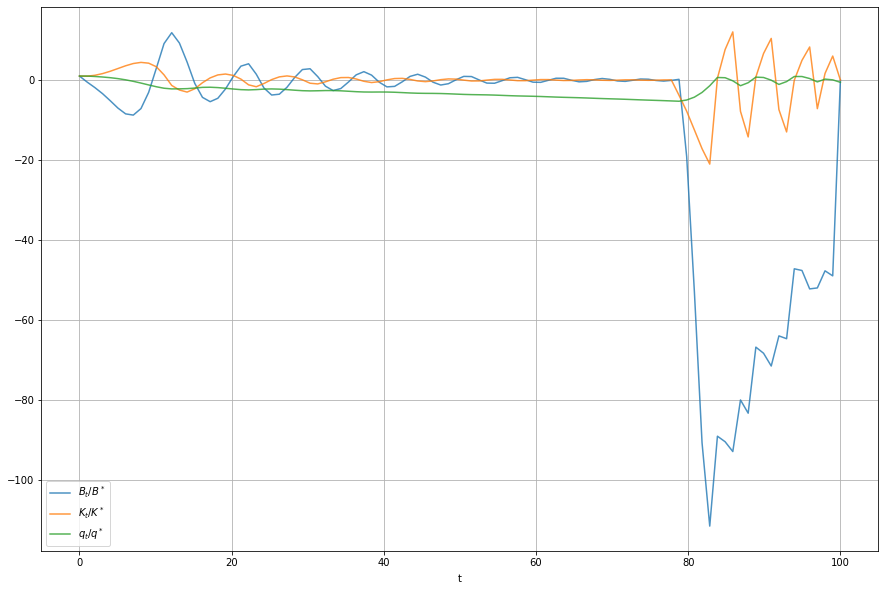

In [362]:
B_graph = B_mat[1, :]/B_star
K_graph = K_mat[1, :]/K_star
q_graph = q_mat[1, :]/q_star

plt.figure(1, figsize=(15,10))
plt.plot(time, B_graph, alpha=0.8, label='$B_t/B^*$')
plt.plot(time, K_graph, alpha=0.8, label='$K_t/K^*$')
plt.plot(time, q_graph, alpha=0.8, label='$q_t/q^*$')
plt.xlabel("$\mathrm{t}$")
plt.legend()
plt.grid()
#lt.xlim(0, 40)
#plt.ylim(-20, 20)

In [0]:
q

In [0]:
for t in range(1, periods):
  def f(variables):
    (q_tplus1, K_t, B_t) = variables
    first_eq = q_tplus1 - R*(q[t] - K_t - v)
    sec_eq = K_t - (1 - π)*λ*K[t-1] - ((π)/(ϕ + q[t] - (1/R)*q_tplus1))*( (a_t[t] + q[t] + λ*ϕ)*K[t-1] - R*B[t-1])
    third_eq = B_t - R*B[t] - q[t]*(K[t]-K[t-1]) - ϕ*(K[t]-λ*K[t-1]) + a_t[t]*K[t-1]
    return [first_eq, sec_eq, third_eq]

  solution = opt.fsolve(f, (0, 0, 0))
  print(solution)

  q[t+1], K[t], B[t] = solution

In [0]:
plt.plot(time, B, alpha=0.5)
plt.plot(time, K, alpha=0.5)
plt.plot(time, q, alpha=0.5)